In [34]:
### Variables Selection
TYPE_PC = False # True For Mac   -   False Ubuntu
DATASET = "AMZ" # AMZ, HC, PM, UN, TOY
NODE_TYPE = True # True=TOP, False=Bot

In [35]:
import sys

if TYPE_PC:
    sys.path.append('/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/05-CommunityDetection/')
else:
    sys.path.append('/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/05-CommunityDetection/')

import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import auxiliar_path

In [68]:
### Global variables

PATH_DATASET = auxiliar_path.get_path_dataset(DATASET)
PATH_NODETYPE = auxiliar_path.get_path_topbot(NODE_TYPE)

if TYPE_PC:
    GLOBAL_PATH = "/Users/ddiaz/Documents/code/phd-thesis-lab/12-third_year/"    
else:
    GLOBAL_PATH = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/"

# File CSVpa
### GLOBAL variables
GRAPH_PATH = ( GLOBAL_PATH + "00-Data/" + PATH_DATASET + "/02-Graphs/" +
              PATH_NODETYPE + "/" +
              "AMZ_top_resall_DF_alpha15.graphml"
              )
# print(GRAPH_PATH)
GRAPH_PATH = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/top/actor-movie_top_simple_noise_alp0.1.graphml"

#
#"AMZ_bot_hyperbolic_DF_alpha2.graphml"
#"HC_bot_master_DF_alpha2.graphml"
#"HC_bot_weights_DF_alpha2.graphml"

In [69]:
### Read GRAPH

g = ig.read(GRAPH_PATH)
print(g.summary(), "\n")

print("Graph info:")
print("\t|V| =", g.vcount())
print("\t|E| =", g.ecount())
print("\t d  =", g.density()) 

IGRAPH U-W- 382219 15036068 -- 
+ attr: fedge (g), fnode (g), fweight (g), id (v), p_value (e), weight (e) 

Graph info:
	|V| = 382219
	|E| = 15036068
	 d  = 0.00020584525917628562


### Detección de comunidades

In [70]:
### Community Detection

comms = g.community_multilevel(weights=g.es["weight"])
g.vs["cls"] = comms.membership
print(comms.summary(), "\n")
comms_with_one = {subgraph.vs["cls"][0]: subgraph for i, subgraph in enumerate(comms.subgraphs()) if len(subgraph.vs) > 5}
comms_to_remove = [sg for sg in comms.subgraphs() if len(sg.vs) <= 5]
nodes_to_remove = []
for i in comms_to_remove:
    for node in i.vs:
        nodes_to_remove.append(node["id"])
len(nodes_to_remove)
asd = []
for node in nodes_to_remove:
    asd.append(g.vs.find(id_eq=node).index)
g.delete_vertices(asd)
print(g.summary())
new_ids_comms = 5000
for com in comms_with_one.values():
    if com.density() > 0.5:        
        new_partition = com.community_multilevel(weights=com.es["weight"])
        for new_comms in new_partition.subgraphs():
            for nodes in new_comms.vs():
                node_to_add = g.vs.find(id_eq=nodes["id"])
                node_to_add["cls"] = new_ids_comms
            new_ids_comms += 1
print("Total Comms", len(set(g.vs["cls"])))

Clustering with 382219 elements and 2113 clusters 

IGRAPH U-W- 377686 15030149 -- 
+ attr: fedge (g), fnode (g), fweight (g), cls (v), id (v), p_value (e), weight (e)
Total Comms 780


In [49]:
def internal_external_degree_node(node):
    """Compute the internal degree k_i^int of node i in a community C."""
    node_neighs = node.neighbors()
    node_community = node["cls"]

    internal_degree = [1 for i in node_neighs if i["cls"]==node_community]
    external_degree = [1 for i in node_neighs if i["cls"]!=node_community]
    
    return sum(internal_degree), sum(external_degree)


def check_strong_community(graph, communities):
    """Returns if it is a strong community."""

    dict_to_ret = {}
    otro = {}
    tercer_dato = {}
    contador_indice = 0

    for id_c in set(g.vs["cls"]):
        flag_weak_comm = False
        porcentaje = 0
        comms = g.vs.select(cls_eq=id_c)
        for node in comms:
            vertex = g.vs.find(id_eq=node["id"])
            int_degree, ext_degree = internal_external_degree_node(vertex)
            if int_degree <= ext_degree:
                flag_weak_comm = True
                porcentaje += 1
        subgrafo = g.induced_subgraph(comms)
        if flag_weak_comm:
            dict_to_ret[id_c] = [comms, False, porcentaje/len(comms)]
            otro[str(contador_indice)] = [len(comms), porcentaje/len(comms)]
            tercer_dato[str(contador_indice)] = [porcentaje/len(comms), subgrafo.density(), len(comms)]
        else:
            dict_to_ret[id_c] = [comms, True, 0]
            otro[str(contador_indice)] = [len(comms), 0]
            tercer_dato[str(contador_indice)] = [0, subgrafo.density(),len(comms)]
        contador_indice += 1
    return dict_to_ret, otro, tercer_dato

In [71]:
strongcomms, otro_dato, tercero = check_strong_community(g, comms_with_one)
print("Total Comms: ", len(strongcomms))

contador = 0
contador_striong = 0
for porcentaje in strongcomms.values():
    contador += porcentaje[2]
    if porcentaje[1]:
        contador_striong+=1

print("Nodos puente", contador / len(strongcomms))
print("Comunidades strong", contador_striong)
totwak = len(strongcomms)-contador_striong
print("Comunidades weak", totwak, "Procentaje:", totwak*100/len(strongcomms))

KeyboardInterrupt: 

In [ ]:
# Obtener las asignaciones de comunidad desde el atributo 'cls' de los nodos
membership = [node["cls"] for node in g.vs]  # vs es la lista de vértices (nodos)

# Calcular la modularidad
modularity_value = g.modularity(membership)

print(f"El valor de modularidad es: {modularity_value}")

El valor de modularidad es: 0.5647228639900508


In [ ]:
def calculate_normalized_k_int_ext(g, community_attr="cls"):
    """
    Calcula k_int_ext normalizado (proporción de conexiones externas/totales).
    """
    normalized_k = {}
    communities = set(g.vs[community_attr])
    
    for c in communities:
        nodes_in_c = [v.index for v in g.vs if v[community_attr] == c]
        
        # Calcular conexiones internas y externas
        internal = 0
        external = 0
        for u in nodes_in_c:
            for v in g.neighbors(u):
                if g.vs[v][community_attr] == c:
                    internal += 1
                else:
                    external += 1
        # Para grafos no dirigidos, dividir internas por 2
        internal = internal // 2
        
        total = internal + external
        normalized_k[c] = external / total if total > 0 else 0.0  # Evitar división por 0
    
    return normalized_k

# Ejemplo:
normalized_values = calculate_normalized_k_int_ext(g, community_attr="cls")
print("k_int_ext normalizado por comunidad:", normalized_values)

k_int_ext normalizado por comunidad: {0: 0.7537414965986394, 1: 0.5836584806059215, 2: 0.40977218225419665, 3: 0.336802270577105, 4: 0.5827439886845828, 5: 0.38044573310071994, 6: 0.7102702702702702, 7: 0.7268558326167956, 8: 0.32432432432432434, 9: 0.8016502697556331, 10: 0.6213026166097838, 11: 0.7926186291739895, 12: 0.43293733985557886, 13: 0.464874632934267, 14: 0.43289224952741023, 15: 0.6998373101952278, 16: 0.7304147465437788, 17: 0.6066536203522505, 18: 0.3189718482252142, 19: 0.7348008385744235, 22: 0.37530300869813205, 23: 0.3471634208298052, 24: 0.5427905427905428, 25: 0.6097293343087052, 26: 0.27662037037037035, 27: 0.6425255338904364, 28: 0.004092769440654843, 32: 0.671957671957672, 34: 0.6648998822143698, 35: 0.5949612403100775, 36: 0.7152542372881356, 41: 0.1111111111111111, 43: 0.6984126984126984, 49: 0.7692307692307693, 53: 0.45803571428571427, 65: 0.2, 5000: 0.25}


In [ ]:
sum(normalized_values.values()) / len(normalized_values)

0.5237204590789003

In [ ]:
g = ig.read(GLOBAL_PATH + "/05-CommunityDetection/dblp.edgelist")
g = g.as_undirected()
g.vs["id"] = [v.index for v in g.vs()]

Iteración 0
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 1
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 2
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 3
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 4
Fin refinamiento
Inicio Nodos
Fin Nodos


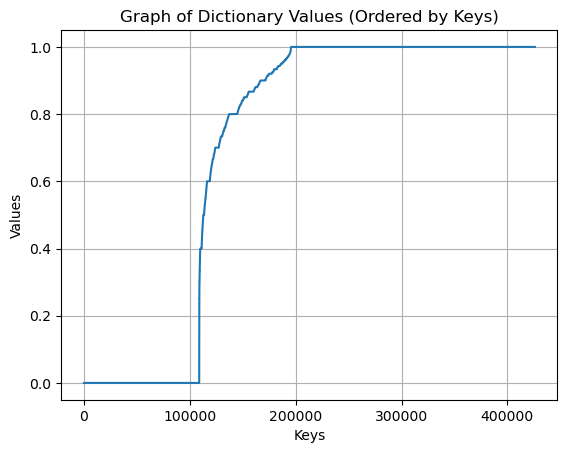

In [68]:
import igraph as ig
import random
from itertools import combinations
from collections import defaultdict

def jaccard_index(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0.0

def refine_communities(g, partition, density_threshold=0.5):
    refined_membership = [-1] * g.vcount()
    current_label = 0

    for comm_id in range(len(partition)):
        nodes = partition[comm_id]
        subgraph = g.subgraph(nodes)
        density = subgraph.density()

        if density < density_threshold and len(nodes) > 3:
            # Reaplicar Louvain en el subgrafo
            sub_partition = subgraph.community_multilevel()
            for sub_comm in sub_partition:
                for i in sub_comm:
                    refined_membership[nodes[i]] = current_label
                current_label += 1
        else:
            # Conservar comunidad original
            for node in nodes:
                refined_membership[node] = current_label
            current_label += 1

    return refined_membership

def run_louvain_iterations(g, iterations=10):
    same_community_neighbors = defaultdict(list)
    
    for _ in range(iterations):
        print("Iteración", _)
        partition = g.community_multilevel()

        #refined_membership = refine_communities(g, partition)
        print("Fin refinamiento")
        # Mapa rápido de nodo -> comunidad
        #node_to_comm = {v.index: refined_membership[v.index] for v in g.vs}
        membership = partition.membership

        # Creamos un mapa rápido de nodo -> comunidad
        node_to_comm = {v.index: membership[v.index] for v in g.vs}

        print("Inicio Nodos")
        for v in g.vs:
            v_id = v["id"]
            community_neighbors = set()

            for neighbor in g.neighbors(v):
                if node_to_comm[neighbor] == node_to_comm[v.index]:
                    community_neighbors.add(g.vs[neighbor]["id"])

            same_community_neighbors[v_id].append(community_neighbors)
        print("Fin Nodos")
    return same_community_neighbors

def compute_jaccard_stability(same_community_neighbors):
    stability_scores = {}

    for node_id, neighbor_sets in same_community_neighbors.items():
        if len(neighbor_sets) < 2:
            stability_scores[node_id] = 1.0
            continue

        jaccard_scores = []
        for s1, s2 in combinations(neighbor_sets, 2):
            jaccard_scores.append(jaccard_index(s1, s2))

        stability_scores[node_id] = sum(jaccard_scores) / len(jaccard_scores)

    return stability_scores

# Ejecutar el experimento
neighbors_by_iteration = run_louvain_iterations(g, iterations=5)
jaccard_stability = compute_jaccard_stability(neighbors_by_iteration)

# Create the plot
plt.plot(range(len(jaccard_stability.values())), sorted(list(jaccard_stability.values())))
plt.xlabel("Keys")
plt.ylabel("Values")
plt.title("Graph of Dictionary Values (Ordered by Keys)")
plt.grid(True)
plt.show()

In [169]:
### Global variables
### Variables Selection
TYPE_PC = False # True For Mac   -   False Ubuntu
DATASET = "AMZ" # AMZ, HC, PM, UN, TOY
NODE_TYPE = False

PATH_DATASET = auxiliar_path.get_path_dataset(DATASET)
PATH_NODETYPE = auxiliar_path.get_path_topbot(NODE_TYPE)

if TYPE_PC:
    GLOBAL_PATH = "/Users/ddiaz/Documents/code/phd-thesis-lab/12-third_year/"    
else:
    GLOBAL_PATH = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/"

# File CSVpa
### GLOBAL variables
GRAPH_PATH = ( GLOBAL_PATH + "00-Data/" + PATH_DATASET + "/02-Graphs/" +
              PATH_NODETYPE + "/" +
              "AMZ_bot_weights_NC_alph05.graphml"
              )
# print(GRAPH_PATH)
### Community Detection
g = ig.read(GRAPH_PATH)
print(g.summary())

IGRAPH U-WT 7518 64722 -- 
+ attr: freq (v), id (v), type (v), weight (e)


In [133]:

comms = g.community_multilevel(weights=g.es["weight"])
g.vs["cls"] = comms.membership
print(comms.summary(), "\n")
comms_with_one = {subgraph.vs["cls"][0]: subgraph for i, subgraph in enumerate(comms.subgraphs()) if len(subgraph.vs) > 5}
comms_to_remove = [sg for sg in comms.subgraphs() if len(sg.vs) <= 5]
nodes_to_remove = []
for i in comms_to_remove:
    for node in i.vs:
        nodes_to_remove.append(node["id"])
len(nodes_to_remove)
asd = []
for node in nodes_to_remove:
    asd.append(g.vs.find(id_eq=node).index)
g.delete_vertices(asd)
print(g.summary())
new_ids_comms = 5000
for com in comms_with_one.values():
    if com.density() > 0.5:        
        new_partition = com.community_multilevel(weights=com.es["weight"])
        for new_comms in new_partition.subgraphs():
            for nodes in new_comms.vs():
                node_to_add = g.vs.find(id_eq=nodes["id"])
                node_to_add["cls"] = new_ids_comms
            new_ids_comms += 1
print("Total Comms", len(set(g.vs["cls"])))

def internal_external_degree_node(node):
    """Compute the internal degree k_i^int of node i in a community C."""
    node_neighs = node.neighbors()
    node_community = node["cls"]

    internal_degree = [1 for i in node_neighs if i["cls"]==node_community]
    external_degree = [1 for i in node_neighs if i["cls"]!=node_community]
    
    return sum(internal_degree), sum(external_degree)


def check_strong_community(graph, communities):
    """Returns if it is a strong community."""

    dict_to_ret = {}
    otro = {}
    tercer_dato = {}
    contador_indice = 0

    for id_c in set(g.vs["cls"]):
        flag_weak_comm = False
        porcentaje = 0
        comms = g.vs.select(cls_eq=id_c)
        for node in comms:
            vertex = g.vs.find(id_eq=node["id"])
            int_degree, ext_degree = internal_external_degree_node(vertex)
            if int_degree <= ext_degree:
                flag_weak_comm = True
                porcentaje += 1
        subgrafo = g.induced_subgraph(comms)
        if flag_weak_comm:
            dict_to_ret[id_c] = [comms, False, porcentaje/len(comms)]
            otro[str(contador_indice)] = [len(comms), porcentaje/len(comms)]
            tercer_dato[str(contador_indice)] = [porcentaje/len(comms), subgrafo.density(), len(comms)]
        else:
            dict_to_ret[id_c] = [comms, True, 0]
            otro[str(contador_indice)] = [len(comms), 0]
            tercer_dato[str(contador_indice)] = [0, subgrafo.density(),len(comms)]
        contador_indice += 1
    return dict_to_ret, otro, tercer_dato

Clustering with 4930 elements and 862 clusters 

IGRAPH U-WT 4076 425718 -- 
+ attr: cls (v), freq (v), id (v), type (v), weight (e)
Total Comms 13


In [134]:
strongcomms, otro_dato, tercero = check_strong_community(g, comms_with_one)
print("Total Comms: ", len(strongcomms))

contador = 0
contador_striong = 0
for porcentaje in strongcomms.values():
    contador += porcentaje[2]
    if porcentaje[1]:
        contador_striong+=1

print("Nodos puente", contador / len(strongcomms))
print("Comunidades strong", contador_striong)
print("Comunidades weak", len(strongcomms)-contador_striong)

Total Comms:  13
Nodos puente 0.6537017510951169
Comunidades strong 0
Comunidades weak 13


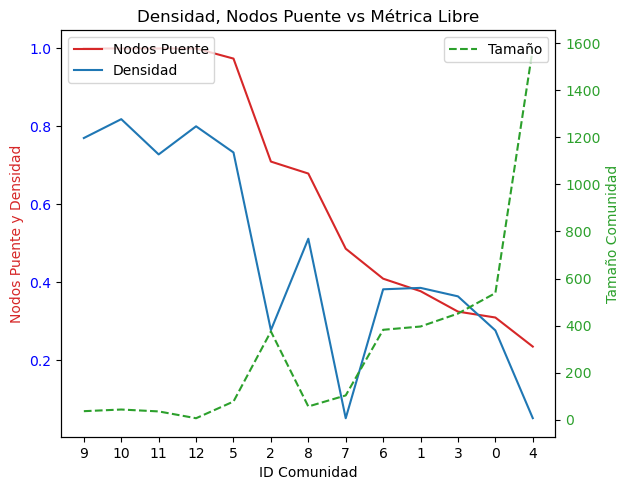

In [135]:
import matplotlib.pyplot as plt


def generar_grafica_tres_metricas_doble_eje_y(datos):
    """
    Genera una gráfica con dos ejes Y para visualizar dos métricas (0-1) en un eje
    y una tercera métrica (rango libre) en otro eje, ordenada por la primera métrica (tamaño).

    Args:
        datos (dict): Diccionario donde las claves son los índices y los valores son listas
                      [metrica_0_a_1_a, metrica_0_a_1_b, metrica_libre].
                      Se ordenará por metrica_0_a_1_a.
    """

    # Ordenar los datos por la primera métrica (se asume que es la más importante para el orden)
    datos_ordenados = dict(sorted(datos.items(), key=lambda item: item[1][0], reverse=True))

    indices = list(datos_ordenados.keys())
    metrica_a = [datos_ordenados[indice][0] for indice in indices]
    metrica_b = [datos_ordenados[indice][1] for indice in indices]
    metrica_libre = [datos_ordenados[indice][2] for indice in indices]

    fig, ax1 = plt.subplots()

    # Eje Y izquierdo para las métricas de 0 a 1
    color1 = 'tab:red'
    ax1.set_xlabel('ID Comunidad')
    ax1.set_ylabel('Nodos Puente y Densidad', color=color1)
    ax1.plot(indices, metrica_a, color=color1, label='Nodos Puente')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.plot(indices, metrica_b, color='tab:blue', label='Densidad')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    # Eje Y derecho para la métrica de rango libre
    ax2 = ax1.twinx()  # comparte el mismo eje X
    color2 = 'tab:green'
    ax2.set_ylabel('Tamaño Comunidad', color=color2)
    ax2.plot(indices, metrica_libre, color=color2, linestyle='--', label='Tamaño')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc='upper right')

    fig.tight_layout()  # para evitar que las etiquetas se superongan
    plt.title("Densidad, Nodos Puente vs Métrica Libre")
    plt.show()

# Ejemplo de uso:

generar_grafica_tres_metricas_doble_eje_y(tercero)

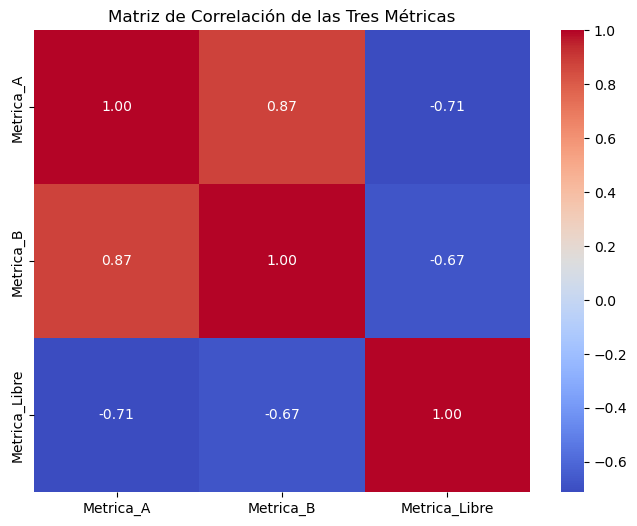

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analizar_correlacion_y_matriz_calor(datos):
    """
    Realiza un análisis de correlación de tres métricas y genera una matriz de calor.

    Args:
        datos (dict): Diccionario donde las claves son los índices y los valores son listas
                      [metrica_0_a_1_a, metrica_0_a_1_b, metrica_libre].
    """
    # Convertir el diccionario a un DataFrame de pandas
    df = pd.DataFrame.from_dict(datos, orient='index', columns=['Metrica_A', 'Metrica_B', 'Metrica_Libre'])

    # Calcular la matriz de correlación
    correlation_matrix = df.corr()

    # Generar la matriz de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de Correlación de las Tres Métricas')
    plt.show()


analizar_correlacion_y_matriz_calor(tercero)

Iteración 0
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 1
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 2
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 3
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 4
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 5
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 6
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 7
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 8
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 9
Fin refinamiento
Inicio Nodos
Fin Nodos


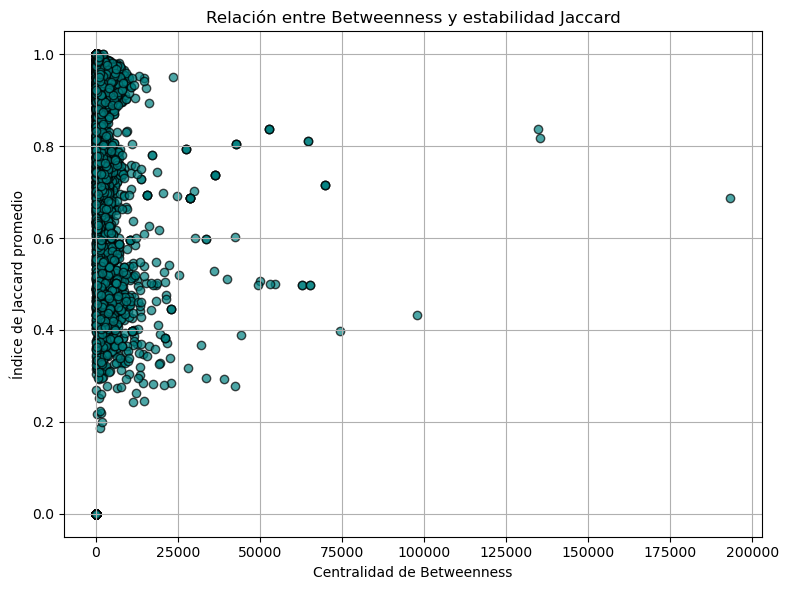

In [140]:
import matplotlib.pyplot as plt


# Ejecutar el experimento
neighbors_by_iteration = run_louvain_iterations(g, iterations=10)
jaccard_stability = compute_jaccard_stability(neighbors_by_iteration)

# Calcular centralidad de betweenness
betweenness = g.betweenness()
betweenness_by_id = {v["id"]: bt for v, bt in zip(g.vs, betweenness)}

# Mostrar comparación
#print(f"\n{'Nodo':>5} | {'Jaccard':>8} | {'Betweenness':>12}")
#print("-" * 32)
#for node_id in sorted(jaccard_stability.keys(), key=lambda x: float(x)):
#    js = jaccard_stability[node_id]
#    bt = betweenness_by_id[node_id]
#    print(f"{node_id:>5} | {js:>8.3f} | {bt:>12.3f}")

# Graficar la relación
x = [betweenness_by_id[n] for n in jaccard_stability]
y = [jaccard_stability[n] for n in jaccard_stability]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c="teal", edgecolors="black", alpha=0.7)
plt.xlabel("Centralidad de Betweenness")
plt.ylabel("Índice de Jaccard promedio")
plt.title("Relación entre Betweenness y estabilidad Jaccard")
plt.grid(True)
plt.tight_layout()
plt.show()


Iteración 0
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 1
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 2
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 3
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 4
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 5
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 6
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 7
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 8
Fin refinamiento
Inicio Nodos
Fin Nodos
Iteración 9
Fin refinamiento
Inicio Nodos
Fin Nodos


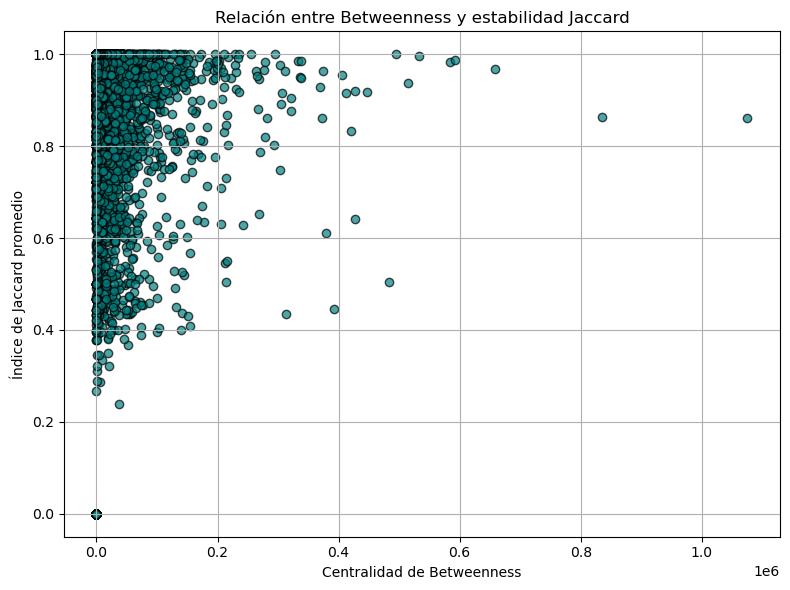

In [157]:
import matplotlib.pyplot as plt


# Ejecutar el experimento
neighbors_by_iteration = run_louvain_iterations(g, iterations=10)
jaccard_stability = compute_jaccard_stability(neighbors_by_iteration)

# Calcular centralidad de betweenness
betweenness = g.betweenness()
betweenness_by_id = {v["id"]: bt for v, bt in zip(g.vs, betweenness)}

# Mostrar comparación
#print(f"\n{'Nodo':>5} | {'Jaccard':>8} | {'Betweenness':>12}")
#print("-" * 32)
#for node_id in sorted(jaccard_stability.keys(), key=lambda x: float(x)):
#    js = jaccard_stability[node_id]
#    bt = betweenness_by_id[node_id]
#    print(f"{node_id:>5} | {js:>8.3f} | {bt:>12.3f}")

# Graficar la relación
x = [betweenness_by_id[n] for n in jaccard_stability]
y = [jaccard_stability[n] for n in jaccard_stability]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c="teal", edgecolors="black", alpha=0.7)
plt.xlabel("Centralidad de Betweenness")
plt.ylabel("Índice de Jaccard promedio")
plt.title("Relación entre Betweenness y estabilidad Jaccard")
plt.grid(True)
plt.tight_layout()
plt.show()


In [159]:
from scipy.stats import pearsonr, spearmanr, kendalltau

# Listas ordenadas de métricas
x = [betweenness_by_id[n] for n in jaccard_stability]
y = [jaccard_stability[n] for n in jaccard_stability]

# Cálculo de correlaciones
pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)
kendall_corr, _ = kendalltau(x, y)

# Mostrar resultados
print("\n📊 Análisis de correlación:")
print(f"  Pearson  : {pearson_corr:.4f}")
print(f"  Spearman : {spearman_corr:.4f}")
print(f"  Kendall  : {kendall_corr:.4f}")



📊 Análisis de correlación:
  Pearson  : 0.0474
  Spearman : -0.1238
  Kendall  : -0.1060


In [160]:
from scipy.stats import pearsonr, spearmanr, kendalltau

def correlate_bridge_nodes_with_betweenness(g):
    bridge_flags = []
    betweenness_vals = []

    betweenness = g.betweenness()
    
    for v in g.vs:
        int_deg, ext_deg = internal_external_degree_node(v)
        is_bridge = 1 if ext_deg > int_deg else 0
        
        bridge_flags.append(is_bridge)
        betweenness_vals.append(betweenness[v.index])

    # Correlaciones
    pearson_corr, _ = pearsonr(bridge_flags, betweenness_vals)
    spearman_corr, _ = spearmanr(bridge_flags, betweenness_vals)
    kendall_corr, _ = kendalltau(bridge_flags, betweenness_vals)

    print("\n📊 Correlación entre ser nodo puente y betweenness:")
    print(f"  Pearson  : {pearson_corr:.4f}")
    print(f"  Spearman : {spearman_corr:.4f}")
    print(f"  Kendall  : {kendall_corr:.4f}")


Clustering with 7518 elements and 299 clusters 

IGRAPH U-WT 7179 64643 -- 
+ attr: cls (v), freq (v), id (v), type (v), weight (e)
Total Comms 28

📊 Correlación entre ser nodo puente y betweenness:
  Pearson  : 0.1653
  Spearman : 0.2462
  Kendall  : 0.2066


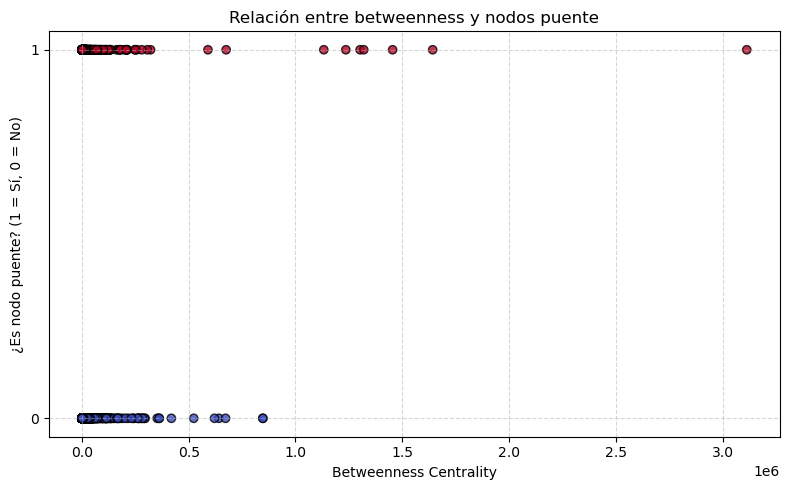

In [171]:
# Asignar comunidades (por ejemplo, con Louvain)
partition = g.community_multilevel()
comms = g.community_multilevel(weights=g.es["weight"])
g.vs["cls"] = comms.membership
print(comms.summary(), "\n")
comms_with_one = {subgraph.vs["cls"][0]: subgraph for i, subgraph in enumerate(comms.subgraphs()) if len(subgraph.vs) > 5}
comms_to_remove = [sg for sg in comms.subgraphs() if len(sg.vs) <= 5]
nodes_to_remove = []
for i in comms_to_remove:
    for node in i.vs:
        nodes_to_remove.append(node["id"])
len(nodes_to_remove)
asd = []
for node in nodes_to_remove:
    asd.append(g.vs.find(id_eq=node).index)
g.delete_vertices(asd)
print(g.summary())
new_ids_comms = 5000
for com in comms_with_one.values():
    if com.density() > 0.5:        
        new_partition = com.community_multilevel(weights=com.es["weight"])
        for new_comms in new_partition.subgraphs():
            for nodes in new_comms.vs():
                node_to_add = g.vs.find(id_eq=nodes["id"])
                node_to_add["cls"] = new_ids_comms
            new_ids_comms += 1
print("Total Comms", len(set(g.vs["cls"])))


# Verificar comunidades fuertes
dict_result, otro, tercer_dato = check_strong_community(g, partition)

# Medir correlación entre puentes y betweenness
correlate_bridge_nodes_with_betweenness(g)


In [165]:
import matplotlib.pyplot as plt

def plot_bridge_vs_betweenness(bridge_flags, betweenness_vals):
    plt.figure(figsize=(8, 5))
    plt.scatter(betweenness_vals, bridge_flags, c=bridge_flags, cmap="coolwarm", edgecolors="black", alpha=0.8)
    plt.xlabel("Betweenness Centrality")
    plt.ylabel("¿Es nodo puente? (1 = Sí, 0 = No)")
    plt.title("Relación entre betweenness y nodos puente")
    plt.yticks([0, 1])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [167]:
def correlate_bridge_nodes_with_betweenness(g):
    bridge_flags = []
    betweenness_vals = []

    betweenness = g.betweenness()
    
    for v in g.vs:
        int_deg, ext_deg = internal_external_degree_node(v)
        is_bridge = 1 if ext_deg > int_deg else 0
        
        bridge_flags.append(is_bridge)
        betweenness_vals.append(betweenness[v.index])

    # Correlaciones
    pearson_corr, _ = pearsonr(bridge_flags, betweenness_vals)
    spearman_corr, _ = spearmanr(bridge_flags, betweenness_vals)
    kendall_corr, _ = kendalltau(bridge_flags, betweenness_vals)

    print("\n📊 Correlación entre ser nodo puente y betweenness:")
    print(f"  Pearson  : {pearson_corr:.4f}")
    print(f"  Spearman : {spearman_corr:.4f}")
    print(f"  Kendall  : {kendall_corr:.4f}")

    # Graficar
    plot_bridge_vs_betweenness(bridge_flags, betweenness_vals)


In [170]:
correlate_bridge_nodes_with_betweenness(g)


KeyError: 'Attribute does not exist'